__Import the modules__

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import glob
from datetime import datetime
import string
from collections import Counter
from tqdm import tqdm, notebook
tqdm.pandas()

# don't display warnings info
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Gensim
# !pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
# set the environment for mallet
os.environ.update({'MALLET_HOME':r'C:\Users\Willa\OneDrive\Desktop\mallet-2.0.8'})
mallet_path = r'C:\Users\Willa\OneDrive\Desktop\mallet-2.0.8\bin\mallet'# update this path

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Nltk for text processing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

# spacy for lemmatization
import spacy


# model storage
import pickle
import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Cleaning 

__Read the scraped FOX News__

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
fox_coronav = pd.read_excel(io.BytesIO(uploaded['CNN_coronavirus_0408 (4).xlsx']))
#fox_coronav = pd.read_excel('foxnews_article_form.xlsx')
fox_coronav.head()

Saving CNN_coronavirus_0408 (4).xlsx to CNN_coronavirus_0408 (4).xlsx


,true_time,headline,link,content
0,27-06-2020,After saving his own life with a repurposed dr...,https://www.cnn.com/2020/06/27/health/coronavi...,"Every morning, Dr. David Fajgenbaum takes thre..."
1,27-06-2020,Novak Djokovic and the Adria Tour: the exhibit...,https://www.cnn.com/2020/06/27/tennis/novak-dj...,Novak Djokovic should have been stepping out t...
2,25-06-2020,"As Delhi becomes India's coronavirus capital, ...",https://www.cnn.com/2020/06/25/india/delhi-hos...,Lakhjeet Singh had been running a fever for da...
3,19-06-2020,June 20 coronavirus news,https://www.cnn.com/world/live-news/coronaviru...,The NFL Players Association issued a statement...
4,20-06-2020,Greta Thunberg says Covid-19 response shows wo...,https://www.cnn.com/2020/06/20/europe/greta-th...,The coronavirus pandemic proves the world can ...


In [ ]:
# drop the nulls, transform the datatime type
fox_coronav = fox_coronav.dropna()
date = datetime.strptime('22-01-2020', '%d-%m-%Y')
fox_coronav.index=pd.to_datetime(fox_coronav['true_time'])
df1 = fox_coronav.loc[fox_coronav.index > date,:]
df1.head()


,true_time,headline,link,content
true_time,,,,
2020-06-27,27-06-2020,After saving his own life with a repurposed dr...,https://www.cnn.com/2020/06/27/health/coronavi...,"Every morning, Dr. David Fajgenbaum takes thre..."
2020-06-27,27-06-2020,Novak Djokovic and the Adria Tour: the exhibit...,https://www.cnn.com/2020/06/27/tennis/novak-dj...,Novak Djokovic should have been stepping out t...
2020-06-25,25-06-2020,"As Delhi becomes India's coronavirus capital, ...",https://www.cnn.com/2020/06/25/india/delhi-hos...,Lakhjeet Singh had been running a fever for da...
2020-06-19,19-06-2020,June 20 coronavirus news,https://www.cnn.com/world/live-news/coronaviru...,The NFL Players Association issued a statement...
2020-06-20,20-06-2020,Greta Thunberg says Covid-19 response shows wo...,https://www.cnn.com/2020/06/20/europe/greta-th...,The coronavirus pandemic proves the world can ...


In [ ]:
df = df1
#df["true_time"] = pd.to_datetime(df["true_time"])
#pd.options.mode.chained_assignment = None
#df = df.sort_values(by ='true_time').reset_index(drop = False)
#del df['Unnamed: 0']
df.head(10)

,true_time,headline,link,content
true_time,,,,
2020-06-27,2020-06-27,After saving his own life with a repurposed dr...,https://www.cnn.com/2020/06/27/health/coronavi...,"Every morning, Dr. David Fajgenbaum takes thre..."
2020-06-27,2020-06-27,Novak Djokovic and the Adria Tour: the exhibit...,https://www.cnn.com/2020/06/27/tennis/novak-dj...,Novak Djokovic should have been stepping out t...
2020-06-25,2020-06-25,"As Delhi becomes India's coronavirus capital, ...",https://www.cnn.com/2020/06/25/india/delhi-hos...,Lakhjeet Singh had been running a fever for da...
2020-06-19,2020-06-19,June 20 coronavirus news,https://www.cnn.com/world/live-news/coronaviru...,The NFL Players Association issued a statement...
2020-06-20,2020-06-20,Greta Thunberg says Covid-19 response shows wo...,https://www.cnn.com/2020/06/20/europe/greta-th...,The coronavirus pandemic proves the world can ...
2020-05-15,2020-05-15,Spain's Mallorca eyes German travelers by late...,https://www.cnn.com/travel/article/spain-mallo...,Spain's Mallorca island in the Mediterranean p...
2020-06-15,2020-06-15,June 16 coronavirus news,https://www.cnn.com/world/live-news/coronaviru...,Our live coverage of the coronavirus pandemic ...
2020-12-06,2020-12-06,The pandemic could have ruined this sustainabl...,https://www.cnn.com/2020/06/12/business/loop-r...,Editor's Note: The content in this story is pa...
2020-06-15,2020-06-15,What it's like to fly on Europe's biggest airl...,https://www.cnn.com/travel/article/flying-in-e...,European travelers have begun returning to the...


In [ ]:
# check for duplicated rows 
df[df.duplicated(subset = 'content')]

,true_time,headline,link,content
true_time,,,,


In [ ]:
# drop the duplicated rows 
df.drop_duplicates(subset = 'content', inplace = True)

__Check the 'stop sentences'__

In [ ]:
all_news = ' '.join(''.join(df['content']).split('\xa0')) #exclude \xa0
all_news_sentences = sent_tokenize(all_news) # get all the sentences
Counter(all_news_sentences).most_common()

[('Gov.', 8),
 ('Read more here.', 7),
 ('The total includes cases from all 50 states, the District of Columbia and other US territories, as well as all repatriated cases.',
  7),
 ('The totals include cases from all 50 states, the District of Columbia and other US territories, as well as repatriated cases.',
  6),
 ('Read the full story here.', 4),
 ('Follow the latest developments from around the globe here.', 4),
 ('The totals includes cases from all 50 states, the District of Columbia and other US territories, as well as repatriated cases.',
  3),
 ('"Our live coverage of the coronavirus pandemic has moved here.', 3),
 ('Kansas Gov.', 3),
 ('California Gov.', 3),
 ('New Jersey Gov.', 3),
 ('How do they work?', 3),
 ('Why is this test important?', 3),
 ('What are the holdups?', 3),
 ('Arkansas Gov.', 3),
 ('Minnesota Gov.', 3),
 ('Remember: As stocks settle after the trading day, levels might still change slightly.',
  3),
 ('Wyoming is the only state not reporting a death from coro

In [ ]:
stop_sentences = ['contributed to this', 
                  'This material may not be published, broadcast, rewritten, or redistributed', 
                  'FOX News Network, LLC', 
                  'All rights reserved',
                  'All market data delayed',
                  'Sign up here',
                  "Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox Subscribed You've successfully subscribed to this newsletter! This material may not be published, broadcast, rewritten, or redistributed",
                  "LIMITED TIME OFFER, ",
                  r"Learn about all the*",
                  r'Get[ ]*latest[ ]*news',
                  r"delivered[ ]*daily[ ]*inbox",
                  r"Check out what's clicking[ ,\w]*",
                  r"successfully subscribed to[ ,\w]*",
                  r"Thank you for making us your first choice[ ,\w]*",
                  r"Flash top[ \w,]*headlines",
                  r"CLICK HERE*",
                  "Mobile users click here",
                  r"Fun stories about [\w,]* and more",
                  r"Stay up-to-date on the biggest [\w,]* news with our weekly recap",
                  r"originally appeared on [\w,]*",
                  r"originally published on [\w,]*",
                  r"Get a daily look at[ \w,]*",
                  "Fox Nation",
                  "The FOX NEWS RUNDOWN",
                  "subscribe and download",
                  "FOX platforms",
                  "FOX NOW",
                  "FOX NEWS APPFox News",
                  "Fox News First",
                  "copyright",
                  "Follow below on the Fox News live blog",
                  "Kim Komando Show",
                  # stop sentences from CNN
                  'Watch the latest videos on Covid-19.',
                  r'live[ ]*coverage[ ]*of[ \w]*',
                  "Note: The prices above reflect the retailer's listed price at the time of publication.",
                  "Read the full story here.",
                  r"CNN Coronavirus",
                  r"A version of this article first appeared",
                  "You can sign up for free right here",
                  "At CNN, we start with the facts.",
                  "Visit CNN's home for Facts First.",
                  "delivered to your inbox daily.",
                  "Sign up here."
                  ]
stop_sentences = [*map(lambda x: x.lower(), stop_sentences)]

__Delete stop sentences__

In [ ]:
def contain_stop_sentences(sentence):
    '''
    extract the sentences that contain stop sentences
    '''
    check_status = [*map(lambda x: bool(re.search(x, sentence)), stop_sentences)]
    return(any(check_status)) 

In [ ]:
def extract_no_stop_sentences(text_data):
    '''
    Applied on dataframe's column level,
    to delete the stop sentences from a whole news article
    '''
    single_news = ' '.join(''.join(text_data).lower().split('\xa0')) #exclude \xa0
    single_news_sentences = sent_tokenize(single_news)
    new_sentences = []
    for x in single_news_sentences:
        if contain_stop_sentences(x) is False:
            new_sentences.append(x)
    single_new_news = ' '.join(new_sentences)
    
    return(single_new_news)

In [ ]:
new_news_list = df['content'].progress_apply(extract_no_stop_sentences)
df.loc[:,'true_content'] = new_news_list

100%|██████████| 98/98 [00:00<00:00, 118.83it/s]


## Pre-process the text before stemming

In [ ]:
# remove punctuations
def make_lower(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    text = re.sub("\'", "", text)
    return re.sub(r'[^\w\s]', ' ', text)

def strip_extraspace(text):
    return ' '.join(text.split())

def remove_digits(text):
    return re.sub('\d', ' ', text)

def replace_word(text,word,replacement):
    return text.replace(word,replacement)

def remove_words(text,wordlist):
    for word in wordlist:
        if word in text.split():
            text = re.sub(r'\b{}\b'.format(word), '', text)  
    return text

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.append('coronavirus')
stop_words.append('fox')

In [ ]:
def clean_text(text):
    text = make_lower(text)
    text = replace_word(text,'covid-19','covid') 
    text = replace_word(text,'corona virus','coronavirus') 
    text = replace_word(text,'covid','coronavirus') 
    text = replace_word(text,'fox news','fox') 
    text = replace_word(text,'new york','newyork')
    text = replace_word(text, 'begin video clip', '')
    text = replace_word(text, 'commercial break', '')
    text = remove_punctuation(text)
    text = remove_digits(text)
    text = remove_words(text,stop_words)
    
    return text

In [ ]:
df['clean_content'] = df['true_content'].progress_apply(lambda x:clean_text(x))
data = df.clean_content.values.tolist()

100%|██████████| 98/98 [00:05<00:00, 19.21it/s]


## Tokenize and lemmatize words

__Tokenize the pre-processed words__

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [ ]:
data_words = list(sent_to_words(data))
data_words[:2]

[['every',
  'morning',
  'dr',
  'david',
  'fajgenbaum',
  'takes',
  'three',
  'life',
  'saving',
  'pills',
  'wakes',
  'month',
  'old',
  'daughter',
  'amelia',
  'help',
  'feed',
  'usually',
  'grabs',
  'greek',
  'yogurt',
  'eat',
  'quickly',
  'sitting',
  'home',
  'office',
  'spends',
  'next',
  'hours',
  'leading',
  'dozens',
  'fellow',
  'researchers',
  'volunteers',
  'systematic',
  'review',
  'drugs',
  'physicians',
  'researchers',
  'used',
  'far',
  'treat',
  'team',
  'already',
  'pored',
  'papers',
  'treat',
  'patients',
  'year',
  'old',
  'associate',
  'professor',
  'university',
  'pennsylvania',
  'perelman',
  'school',
  'medicine',
  'leads',
  'school',
  'center',
  'cytokine',
  'storm',
  'treatment',
  'laboratory',
  'last',
  'years',
  'dedicated',
  'life',
  'studying',
  'castleman',
  'disease',
  'rare',
  'condition',
  'nearly',
  'claimed',
  'life',
  'epic',
  'odds',
  'found',
  'drug',
  'saved',
  'life',
  'si

__Lemmatize the tokenized words, keep only adj, noun, verb, adv__

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()
all_news = []
for one_news_list in notebook.tqdm(data_words):
    one_news = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in one_news_list]
    all_news.append(one_news)
    
data_lemmatized = all_news

## Create Bigrams for lemmatized texts

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
data_words_bigrams = make_bigrams(data_lemmatized)

## Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# # Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('across', 1),
  ('act', 2),
  ('additional', 1),
  ('administer', 1),
  ('administration', 1),
  ('advise', 1),
  ('advisory', 1),
  ('affect', 1),
  ('agency', 2),
  ('agent', 2),
  ('ago', 1),
  ('aid', 2),
  ('aim', 2),
  ('alike', 1),
  ('alive', 1),
  ('already', 2),
  ('ambitious', 1),
  ('amelia', 1),
  ('amitabh', 1),
  ('among', 1),
  ('amount', 1),
  ('analysis', 2),
  ('analyst', 3),
  ('anecdotal', 1),
  ('anonymized', 1),
  ('another', 3),
  ('anti', 1),
  ('antiviral', 5),
  ('anyway', 1),
  ('app', 3),
  ('appearance', 1),
  ('applicable', 1),
  ('appointment', 1),
  ('approve', 3),
  ('argument', 1),
  ('around', 2),
  ('around_world', 3),
  ('article', 1),
  ('artillery', 1),
  ('associate', 1),
  ('attack', 2),
  ('available', 2),
  ('base', 5),
  ('beacon', 1),
  ('bearing', 1),
  ('become', 1),
  ('begin', 2),
  ('benefit', 1),
  ('best', 1),
  ('bias', 1),
  ('big', 1),
  ('blind', 1),
  ('blood', 1),
  ('body', 3),
  ('boldly', 1),
  ('boost', 2),
  ('boosteris

# Building LDA Mallet Model

In [ ]:
# train the ldamallet model
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
--2020-07-04 00:18:27--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.8MB/s    in 1.4s    

2020-07-04 00:18:29 (10.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bi

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('company', 0.014022525546356381), ('china', 0.013724173938987096), ('year', 0.010442306257924965), ('pandemic', 0.009771015141344075), ('chinese', 0.007309614380547475), ('week', 0.007309614380547475), ('month', 0.006862086969493548), ('market', 0.006787499067651227), ('april', 0.006414559558439621), ('crisis', 0.006265383754754978)]), (1, [('virus', 0.019504987070557814), ('people', 0.015736978204654598), ('life', 0.010639083856667899), ('test', 0.009752493535278907), ('time', 0.009604728481714075), ('disease', 0.008274842999630588), ('make', 0.006280014776505356), ('work', 0.0061322497229405245), ('fight', 0.006058367196158108), ('data', 0.005688954562246029)]), (2, [('state', 0.025623758375702885), ('trump', 0.019293578908380755), ('health', 0.016094818007340316), ('test', 0.013906192127681067), ('president', 0.011212498737331223), ('order', 0.009427926866224451), ('people', 0.008956530522913229), ('accord', 0.008653490016498872), ('friday', 0.006936260480150847), ('case', 0.

## Find the optimal number of topics for LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=3, limit=21, step=3)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


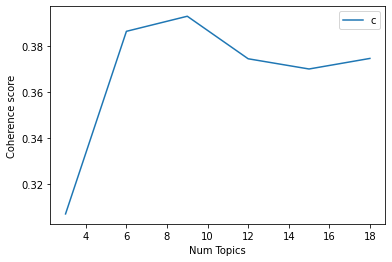

In [ ]:
# Show elbow graph
import matplotlib.pyplot as plt
%matplotlib inline

limit=21; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.307
Num Topics = 6  has Coherence Value of 0.3864
Num Topics = 9  has Coherence Value of 0.393
Num Topics = 12  has Coherence Value of 0.3745
Num Topics = 15  has Coherence Value of 0.37
Num Topics = 18  has Coherence Value of 0.3746


In [ ]:
# select the model based on the coherence-score elbow-plot 
optimal_model = model_list[4]
filename = 'foxcnn_model.sav'
pickle.dump(optimal_model, open(filename, 'wb'))
optimal_model = joblib.load(filename)

In [ ]:
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print("Topics for the chosen LDA model:\n")
pprint(optimal_model.print_topics(num_words=10))

Topics for the chosen LDA model:

[(0,
  '0.021*"people" + 0.015*"police" + 0.014*"authority" + 0.013*"government" + '
  '0.011*"medium" + 0.011*"lockdown" + 0.010*"monday" + 0.010*"quarantine" + '
  '0.009*"accord" + 0.009*"official"'),
 (1,
  '0.041*"case" + 0.023*"death" + 0.023*"accord" + 0.023*"health" + '
  '0.019*"report" + 0.019*"people" + 0.017*"state" + 0.015*"release" + '
  '0.012*"patient" + 0.011*"positive"'),
 (2,
  '0.016*"company" + 0.016*"year" + 0.014*"market" + 0.013*"demand" + '
  '0.012*"week" + 0.011*"stock" + 0.010*"player" + 0.009*"united" + '
  '0.009*"pandemic" + 0.008*"economic"'),
 (3,
  '0.031*"case" + 0.023*"health" + 0.020*"report" + 0.014*"vaccine" + '
  '0.013*"death" + 0.013*"study" + 0.012*"patient" + 0.010*"uk" + 0.010*"june" '
  '+ 0.010*"lockdown"'),
 (4,
  '0.059*"test" + 0.031*"health" + 0.021*"people" + 0.020*"cnn" + '
  '0.016*"thursday" + 0.014*"result" + 0.013*"country" + 0.013*"virus" + '
  '0.012*"pandemic" + 0.012*"spread"'),
 (5,
  '0.039

## Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = optimal_model, corpus = corpus, texts = data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)
df_dominant_topic.to_excel('LDA_foxcnn_colab.xlsx', index = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7,7,11.0,0.5605,"chinese, phone, pandemic, worker, product, pho...",editor note content story part risk t...
34,34,9.0,0.3639,"data, community, disease, people, life, public...",dozens rohingya refugees stranded sea weeks...
37,37,2.0,0.6687,"company, year, market, demand, week, stock, pl...",live coverage ended follow latest stoc...
30,30,8.0,0.2412,"hospital, virus, doctor, world, water, war, ch...",pandemic rages least heroism inspire us...
87,87,2.0,0.4832,"company, year, market, demand, week, stock, pl...",us stocks finished higher thursday recording...
43,43,2.0,0.3464,"company, year, market, demand, week, stock, pl...",world learning live less oil may never l...
24,24,0.0,0.4377,"people, police, authority, government, medium,...",months people france faced énigme n...
42,42,4.0,0.6400,"test, health, people, cnn, thursday, result, c...",one widespread key shortages across supply...
77,77,0.0,0.4214,"people, police, authority, government, medium,...",austrian authorities facing class action law...
91,91,7.0,0.5137,"people, time, feel, make, life, social, family...",like many americans become pajama clad cou...


In [ ]:
df_dominant_topic.to_excel('LDA_foxcnn_colab.xlsx', index = False)

## Find the most representative document for each topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5936,"people, police, authority, government, medium,...",hafiz mohammed naseerudin says police offic...
1,1.0,0.4198,"case, death, accord, health, report, people, s...",dr deborah birx emphasized saturday next tw...
2,2.0,0.6687,"company, year, market, demand, week, stock, pl...",live coverage ended follow latest stoc...
3,3.0,0.4042,"case, health, report, vaccine, death, study, p...",brazilian state rio de janeiro reported rec...
4,4.0,0.6400,"test, health, people, cnn, thursday, result, c...",one widespread key shortages across supply...
5,5.0,0.3697,"state, test, day, people, today, accord, annou...",new zealand recorded jump cases coun...
6,6.0,0.5227,"country, china, government, travel, day, restr...",spain mallorca island mediterranean plans ...
7,7.0,0.5620,"people, time, feel, make, life, social, family...",took full two week beating body went ...
8,8.0,0.5207,"hospital, virus, doctor, world, water, war, ch...",tired washing hands seconds time finge...
9,9.0,0.4305,"data, community, disease, people, life, public...",smoking drinking general poor health resear...


In [ ]:
sent_topics_sorteddf_mallet.to_excel('LDA_foxcnn_colab_rep.xlsx', index = False)

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.set_index('Dominant_Topic')

In [ ]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
0.0,"people, police, authority, government, medium,...",8,0.0816
1.0,"case, death, accord, health, report, people, s...",3,0.0306
2.0,"company, year, market, demand, week, stock, pl...",8,0.0816
3.0,"case, health, report, vaccine, death, study, p...",7,0.0714
4.0,"test, health, people, cnn, thursday, result, c...",3,0.0306
5.0,"state, test, day, people, today, accord, annou...",7,0.0714
6.0,"country, china, government, travel, day, restr...",5,0.0510
7.0,"people, time, feel, make, life, social, family...",8,0.0816
8.0,"hospital, virus, doctor, world, water, war, ch...",9,0.0918
9.0,"data, community, disease, people, life, public...",9,0.0918


In [ ]:
df_dominant_topics.sort_values('Num_Documents', ascending = False).to_excel('LDA_foxcnn_colab_topics.xlsx', index = True)

In [ ]:
pprint(df_dominant_topics.Topic_Keywords)

0.0     people, police, authority, government, medium,...
1.0     case, death, accord, health, report, people, s...
2.0     company, year, market, demand, week, stock, pl...
3.0     case, health, report, vaccine, death, study, p...
4.0     test, health, people, cnn, thursday, result, c...
5.0     state, test, day, people, today, accord, annou...
6.0     country, china, government, travel, day, restr...
7.0     people, time, feel, make, life, social, family...
8.0     hospital, virus, doctor, world, water, war, ch...
9.0     data, community, disease, people, life, public...
10.0    health, week, newyork, ventilator, home, work,...
11.0    chinese, phone, pandemic, worker, product, pho...
12.0    trump, president, state, administration, white...
13.0    reopen, wednesday, order, governor, week, phas...
14.0    virus, drug, human, study, question, spread, g...
Name: Topic_Keywords, dtype: object
